<a href="https://colab.research.google.com/github/musicjae/recommender-system/blob/main/NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References  
[1] https://keras.io/examples/structured_data/collaborative_filtering_movielens/  
[2] [He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international conference on world wide web. 2017.](https://arxiv.org/abs/1708.05031)  
[3] https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929  
[4] https://www.kaggle.com/dalwindr/movielens-recommendation-engine-dalwins001

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0 Import

In [87]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from time import time

In [357]:
from IPython.display import Image

# 1 Data Load

- [데이터셋](http://files.grouplens.org/datasets/movielens/)

In [3]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)

983040/978202 [==============================] - 0s 0us/step


In [4]:
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

Extracting all the files now...
Done!


In [5]:
df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


# 2 Preprocessing  
  
- User indices  
- Item Indices

## 2.1 user2i, movie2i

user_id = df["userId"].unique() 모든 Id의 값만을 다 출력

In [188]:
# user_id = df["userId"].unique() 모든 Id의 값만을 다 출력
user_id = df["userId"].unique().tolist()
print(len(user_id)) 

610


In [189]:
user2i = {x:i for i,x in enumerate(user_id)}# 각 유저 id를 인코딩
i2user = {i:x for i,x in enumerate(user_id)} #위에서 인코딩한 dict을 가지고, 각 인코딩되어 생성된 indices를 각 유저id를 key로 대응하게 해

In [186]:
movie_id = df["movieId"].unique().tolist()
print(len(movie_id))

9724


In [185]:
movie2i = {x:i for i,x in enumerate(movie_id)} # 각 영화 id를 인코딩
i2movie = {i:x for i,x in enumerate(movie_id)} # 각 영화 인덱스를 key로서의 id와 대응

df 내의 모든 유저id에 인덱스 부여

In [10]:
df['user'] = df['userId'].map(user2i) # df 내의 모든 유저id에 인덱스 부여
print(df['user'].head(2))

0    0
1    0
Name: user, dtype: int64


df 내의 모든 영화id에 인덱스 부여

In [11]:
df['movie']=df['movieId'].map(movie2i) # df 내의 모든 영화id에 인덱스 부여
print(df['movie'].head(2))

0    0
1    1
Name: movie, dtype: int64


- user2i와 i2movie 길이  
- df[rating] 변환

In [12]:
num_users = len(user2i)
num_movies = len(i2movie)
df["rating"] = df["rating"].values.astype(np.float32)

print('num_users: ',num_users)
print('num_movies: ',num_movies)
print('\n','df[rating]:\n',df['rating'].head(2))

num_users:  610
num_movies:  9724

 df[rating]:
 0    4.0
1    4.0
Name: rating, dtype: float32


- Norm을 위한 min, max 구하기

In [13]:
min_rating = min(df['rating'])
max_rating = max(df['rating'])
print(min_rating, max_rating)

0.5 5.0


## 2.2 Training/Val dataset

In [14]:
df = df.sample(frac=1, random_state=42) # 학습을 위해 dataset을 random하게 설정
X_data=df[['user', 'movie']]
print(X_data.head(1))

       user  movie
67037   431   4730


In [15]:
y_data =df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values # ratings를 0-1 사이로 Normalization 해줌으로써 학습을 용이하게 만들어준다. to avoid explosion
print(type(y_data))
print(y_data.size)

<class 'numpy.ndarray'>
100836


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(80668, 2)
(20168, 2)
(80668,)
(20168,)


# 3 모델 구축

  
#### 원문 수치들  
    
- Batch size: [128,256,512,1024]  
- Learning Rate: [0.0001,0.0005,0.001,0.005]  
- CF Layer: 32 -> 16 -> 8  
- Emb size: 16

### 3.1 모델 1

- 임베딩 사이즈:16
- 배치 사이즈: 16  
- NN 없음

In [89]:
EMBEDDING_SIZE = 16


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

#### 컴파일

In [90]:
model.compile(loss = keras.losses.BinaryCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
type(model)

In [91]:
start = time()
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size = 16,
                    epochs=10,
                    validation_data=(X_val,y_val))
end = time()

print(end-start)

Epoch 1/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.6306 - val_loss: 0.6109
Epoch 2/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.6059 - val_loss: 0.6046
Epoch 3/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.6001 - val_loss: 0.6023
Epoch 4/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.5968 - val_loss: 0.6009
Epoch 5/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.5951 - val_loss: 0.6002
Epoch 6/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.5933 - val_loss: 0.5999
Epoch 7/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.5925 - val_loss: 0.5999
Epoch 8/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.5914 - val_loss: 0.5999
Epoch 9/10
5042/5042 [==============================] - 22s 4ms/step - loss: 0.5907 - val_loss: 0.5994
Epoch 10/10
5042/5042 [==============================] - 22s 4ms/step - l

In [92]:
model.summary()

Model: "recommender_net_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     multiple                  9760      
_________________________________________________________________
embedding_65 (Embedding)     multiple                  610       
_________________________________________________________________
embedding_66 (Embedding)     multiple                  155584    
_________________________________________________________________
embedding_67 (Embedding)     multiple                  9724      
Total params: 175,678
Trainable params: 175,678
Non-trainable params: 0
_________________________________________________________________


#### 평가

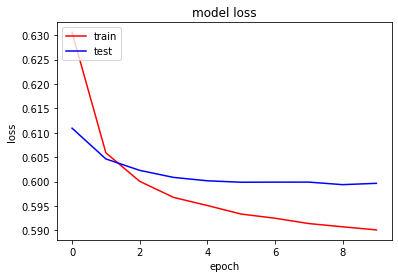

In [93]:
plt.plot(history.history["loss"],c="red")
plt.plot(history.history["val_loss"],c="blue")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### 3.2 모델 2

- 임베딩 사이즈:16
  
- 배치 사이즈: 50
  
- NN 있음. Dense, activation=relu

In [94]:
EMBEDDING_SIZE = 16


class RecommenderNet2(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet2, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.Layer1=layers.Dense(32, activation='relu')
        self.Layer2=layers.Dense(16,activation='relu')
        self.Layer3=layers.Dense(8,activation='relu')
        self.Layer4=layers.Dense(1,activation='sigmoid')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        
        x = self.Layer1(x)
        x = self. Layer2(x)
        x = self.Layer3(x)

        return self.Layer4(x)


model2 = RecommenderNet2(num_users, num_movies, EMBEDDING_SIZE)
model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [95]:
model2.compile(loss = keras.losses.BinaryCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=0.001))

In [97]:
history2 = model2.fit(x=X_train,
                    y=y_train,
                    batch_size = 128,
                    epochs=10,
                    validation_data=(X_val,y_val))

Epoch 1/10
631/631 [==============================] - 4s 6ms/step - loss: 0.6098 - val_loss: 0.6051
Epoch 2/10
631/631 [==============================] - 4s 6ms/step - loss: 0.6063 - val_loss: 0.6031
Epoch 3/10
631/631 [==============================] - 4s 6ms/step - loss: 0.6043 - val_loss: 0.6023
Epoch 4/10
631/631 [==============================] - 4s 6ms/step - loss: 0.6016 - val_loss: 0.6010
Epoch 5/10
631/631 [==============================] - 4s 6ms/step - loss: 0.5996 - val_loss: 0.6004
Epoch 6/10
631/631 [==============================] - 4s 6ms/step - loss: 0.5979 - val_loss: 0.5999
Epoch 7/10
631/631 [==============================] - 4s 6ms/step - loss: 0.5966 - val_loss: 0.5996
Epoch 8/10
631/631 [==============================] - 4s 6ms/step - loss: 0.5958 - val_loss: 0.5994
Epoch 9/10
631/631 [==============================] - 4s 6ms/step - loss: 0.5951 - val_loss: 0.5994
Epoch 10/10
631/631 [==============================] - 4s 6ms/step - loss: 0.5937 - val_loss: 0.5993

#### 평가

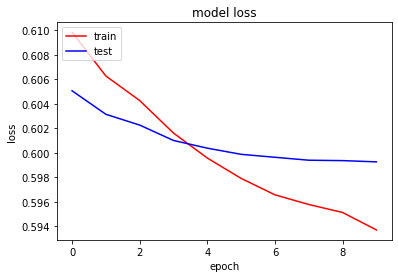

In [98]:
plt.plot(history2.history["loss"],c="red")
plt.plot(history2.history["val_loss"],c="blue")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### 3.3 모델3 

 원문 따라  
 - 임베딩 사이즈 16  
 - 배치 사이즈 128
 - 32->16->8->1 + 배치정규화 + ReLU  
   
==> 학습 속도가 효과적으로 빨라졌다.

In [138]:
EMBEDDING_SIZE = 64


class RecommenderNet3(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet3, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.Layer1=layers.Dense(32)
        self.BN1 = layers.BatchNormalization(axis=-1)
        self.relu = layers.Activation('relu')
        self.Layer2=layers.Dense(16)
        self.BN2 = layers.BatchNormalization(axis=-1)
        self.relu = layers.Activation('relu')
        self.Layer3=layers.Dense(8)
        self.BN3 = layers.BatchNormalization(axis=-1)
        self.relu = layers.Activation('relu')
        self.Layer4=layers.Dense(1,activation='sigmoid')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        
        x = self.relu(self.BN1(self.Layer1(x)))
    
        x = self.relu(self.BN2(self.Layer2(x)))
        x = self.relu(self.BN3(self.Layer3(x)))

        return self.Layer4(x)


model3 = RecommenderNet3(num_users, num_movies, EMBEDDING_SIZE)
model3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [139]:
model3.compile(loss = keras.losses.BinaryCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=0.001))

In [142]:
history3 = model3.fit(x=X_train,
                    y=y_train,
                    batch_size = 64,
                    epochs=50,
                    validation_data=(X_val,y_val))

Epoch 1/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6370 - val_loss: 0.6257
Epoch 2/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6190 - val_loss: 0.6141
Epoch 3/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6073 - val_loss: 0.6075
Epoch 4/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6008 - val_loss: 0.6053
Epoch 5/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.5973 - val_loss: 0.6053
Epoch 6/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.5948 - val_loss: 0.6038
Epoch 7/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.5934 - val_loss: 0.6046
Epoch 8/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.5923 - val_loss: 0.6039
Epoch 9/50
1261/1261 [==============================] - 10s 8ms/step - loss: 0.5916 - val_loss: 0.6031
Epoch 10/50
1261/1261 [==============================] - 10s 8ms/step - l

#### 평가

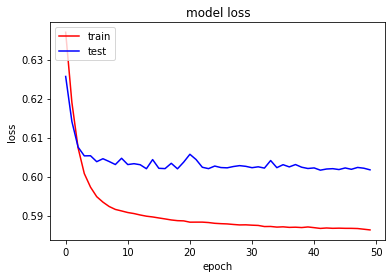

In [143]:
plt.plot(history3.history["loss"],c="red")
plt.plot(history3.history["val_loss"],c="blue")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### 모델들 비교

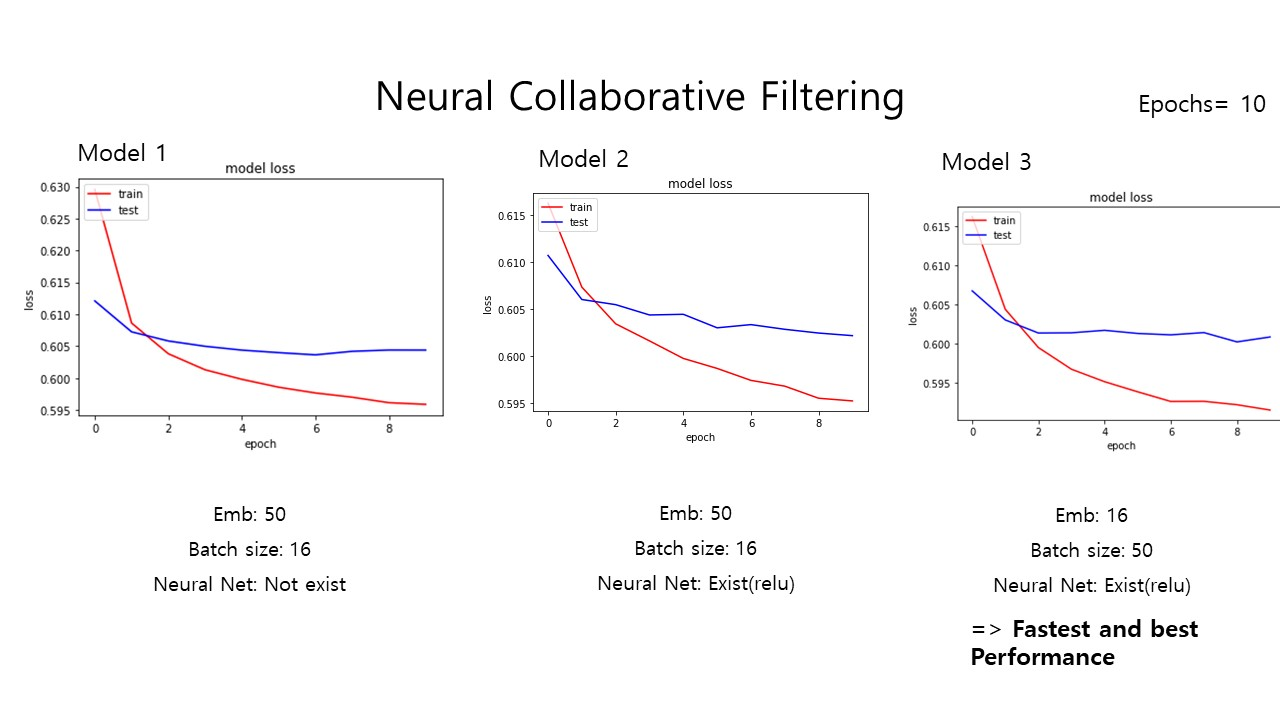

In [361]:
Image('/content/drive/My Drive/datasets/datasets/datas/슬라이드2.JPG',width=800)

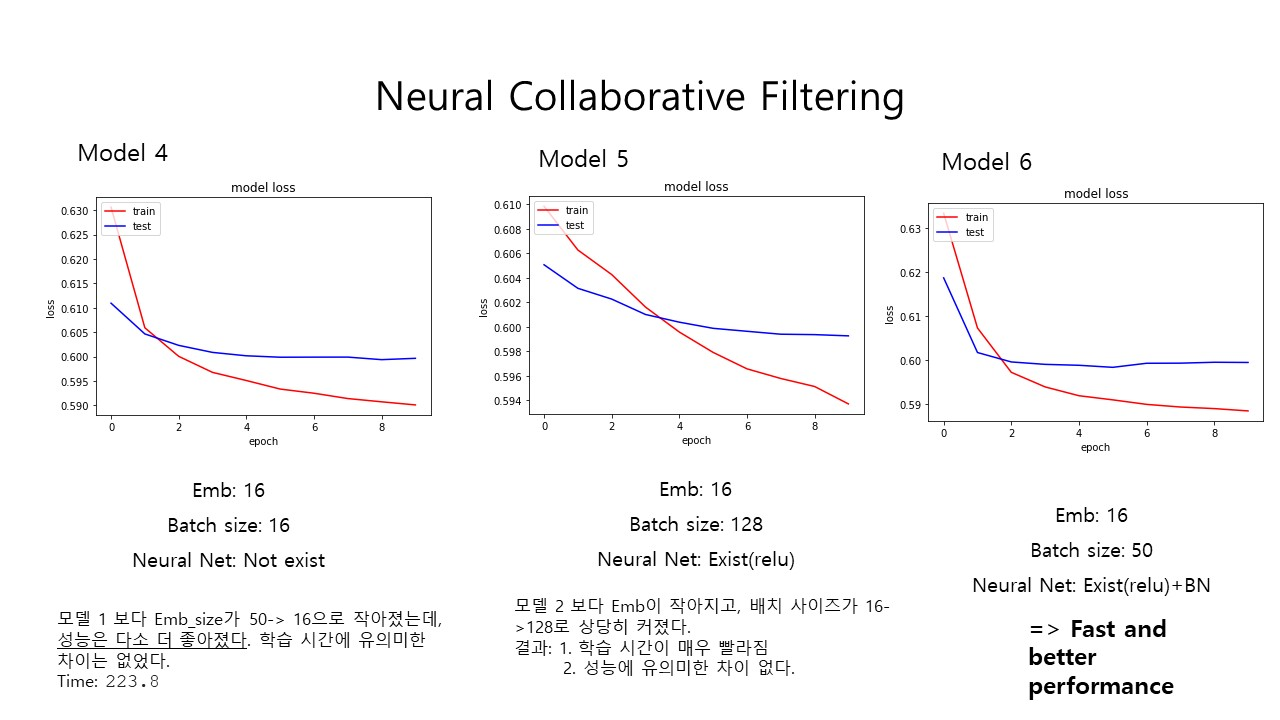

In [363]:
Image('/content/drive/My Drive/datasets/datasets/datas/슬라이드3.JPG',width=800)

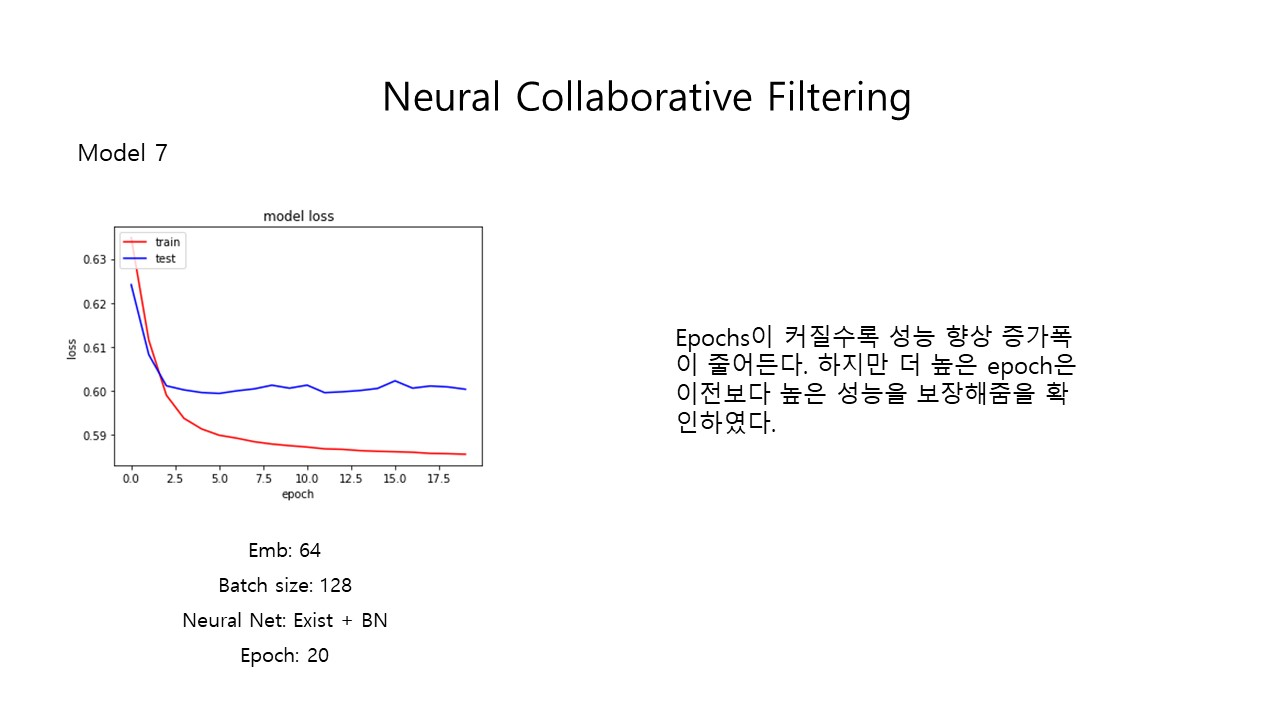

In [366]:
Image('/content/drive/My Drive/datasets/datasets/datas/슬라이드4.JPG',width=700)

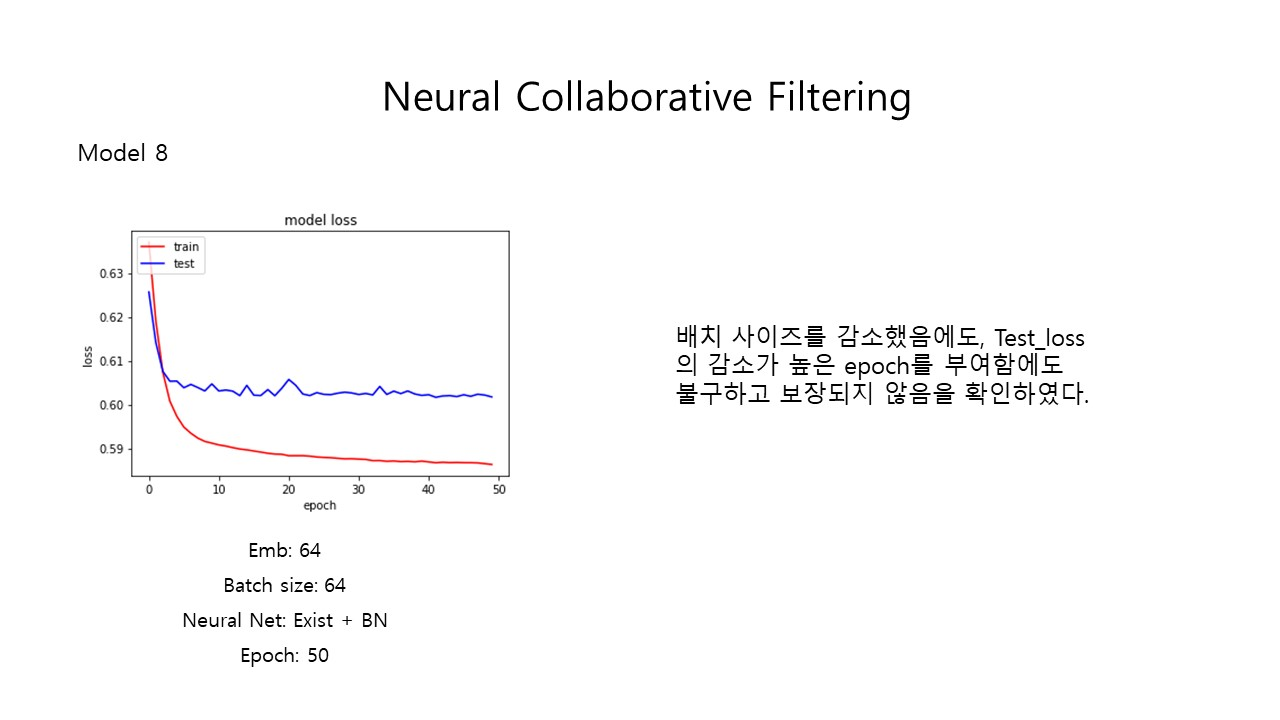

In [365]:
Image('/content/drive/My Drive/datasets/datasets/datas/슬라이드5.JPG',width=700)

# 4 영화 추천해주기

In [305]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [306]:
movie_df.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


##### 임의로 한 명의 유저를 뽑아보자. 이 유저를 A라고 해보자.

In [338]:
user_id = df['userId'].sample(1).iloc[0] # Return a random sample of items from an axis of object.
print(user_id)

587


##### A가 본 영화들과 그가 그 영화들에 대해 매긴 평점 df

In [339]:
movies_watched_by_the_sampled_user = df[df['userId']==user_id]
print(movies_watched_by_the_sampled_user)

       userId  movieId  rating  timestamp  user  movie
90276     587      380     4.0  953138831   586    472
90286     587      590     5.0  953141749   586     32
90382     587     2738     4.0  953139233   586   8914
90336     587     1614     4.0  953139233   586   1499
90325     587     1371     4.0  953142126   586    270
...       ...      ...     ...        ...   ...    ...
90355     587     2239     5.0  953139907   586   5056
90373     587     2539     1.0  953139269   586   1626
90327     587     1373     4.0  953142126   586   1469
90397     587     3260     5.0  953141970   586   2201
90272     587      345     4.0  953138446   586    310

[165 rows x 6 columns]


##### 유저 A가 보지 않은 영화 목록을 df로 만들자.

In [340]:
movies_not_watched_by_the_sampled_user = movie_df[~movie_df['movieId'].isin(movies_watched_by_the_sampled_user['movieId'].values)]

In [341]:
movies_not_watched_by_the_sampled_user

,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [342]:
movies_not_watched_list=[]

for i in movies_not_watched_by_the_sampled_user['movieId']:
    movies_not_watched_list.append(i)

In [343]:
len(movies_not_watched_list)

9577

두 set 간의 교집합

In [344]:
movies_not_watched_list = list(set(movies_not_watched_list).intersection(set(movie2i.keys())))
print(len(movies_not_watched_list)) # 두 set 간의 교집합

9559


In [345]:
movies_not_watched_list = [[movie2i.get(x)] for x in movies_not_watched_list]

#####  user의 인덱스 추출

In [346]:
user_encoder = user2i.get(user_id)
print(user_encoder) # user의 인덱스 추출

118


In [347]:
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched_list), movies_not_watched_list))
print(user_movie_array.shape)

(9559, 2)


### 모델1의 영화 추천 목록

In [348]:
print(ratings.shape)
ratings = model.predict(user_movie_array).flatten()
print(ratings.shape)
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [i2movie.get(movies_not_watched_list[x][0]) for x in top_ratings_indices]
print(top_ratings_indices)
print(recommended_movie_ids)

(9076,)
(9559,)
[1491 3987 3689 6585  412 3362  124 6807 5246 6904]
[1845, 103253, 4571, 142456, 448, 102445, 135, 78499, 72405, 112175]


In [353]:
print("유저 {} 를 위한 추천 목록".format(user_id))
print("====" * 9)
print("유저가 가장 높은 평점을 부여한 영화들")
print("----" * 8)
top_movies_user = (
    movies_watched_by_the_sampled_user.sort_values(by="rating", ascending=False).head(5).movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]

cnt=1
for row in movie_df_rows.itertuples():
    print(cnt,'.',row.title, ":", row.genres,'\n')
    cnt+=1

유저 587 를 위한 추천 목록
유저가 가장 높은 평점을 부여한 영화들
--------------------------------
1 . Usual Suspects, The (1995) : Crime|Mystery|Thriller 

2 . Primal Fear (1996) : Crime|Drama|Mystery|Thriller 

3 . One Flew Over the Cuckoo's Nest (1975) : Drama 

4 . Little Big Man (1970) : Western 

5 . Bull Durham (1988) : Comedy|Drama|Romance 



In [354]:
print("----" * 8)
print("----" * 8)
print("Top 10 영화 추천")
print("----" * 8)
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
cnt=1
for row in recommended_movies.itertuples():
    print(cnt,'.',row.title, ":", row.genres,'\n')
    cnt+=1

--------------------------------
--------------------------------
Top 10 영화 추천
--------------------------------
--------------------------------
1 . Down Periscope (1996) : Comedy 

2 . Fearless (1993) : Drama 

3 . Zero Effect (1998) : Comedy|Mystery|Thriller 

4 . Bill & Ted's Excellent Adventure (1989) : Adventure|Comedy|Sci-Fi 

5 . Bad Lieutenant: Port of Call New Orleans (2009) : Crime|Drama 

6 . Toy Story 3 (2010) : Adventure|Animation|Children|Comedy|Fantasy|IMAX 

7 . Star Trek Into Darkness (2013) : Action|Adventure|Sci-Fi|IMAX 

8 . Elysium (2013) : Action|Drama|Sci-Fi|IMAX 

9 . How to Train Your Dragon 2 (2014) : Action|Adventure|Animation 

10 . The Brand New Testament (2015) : (no genres listed) 



### 모델2의 영화 추천 목록

In [355]:
ratings = model2.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [i2movie.get(movies_not_watched_list[x][0]) for x in top_ratings_indices]

print("모델 2의 유저 {} 를 위한 추천 목록".format(user_id))
print("====" * 9)
print("유저가 가장 높은 평점을 부여한 영화들")
print("----" * 9,)
print(" " * 8)
top_movies_user = (
    movies_watched_by_the_sampled_user.sort_values(by="rating", ascending=False).head(5).movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
cnt=1
for row in movie_df_rows.itertuples():
    print(cnt,'.',row.title, ":", row.genres)
    cnt+=1

print(" " * 8)
print(" " * 8)
print("Top 10 영화 추천")
print("----" * 8)
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
cnt=1
for row in recommended_movies.itertuples():
    print(cnt,'.',row.title, ":", row.genres,'\n')
    cnt+=1

모델 2의 유저 587 를 위한 추천 목록
유저가 가장 높은 평점을 부여한 영화들
------------------------------------
        
1 . Usual Suspects, The (1995) : Crime|Mystery|Thriller
2 . Primal Fear (1996) : Crime|Drama|Mystery|Thriller
3 . One Flew Over the Cuckoo's Nest (1975) : Drama
4 . Little Big Man (1970) : Western
5 . Bull Durham (1988) : Comedy|Drama|Romance
        
        
Top 10 영화 추천
--------------------------------
--------------------------------
1 . Down Periscope (1996) : Comedy 

2 . Drop Zone (1994) : Action|Thriller 

3 . Schindler's List (1993) : Drama|War 

4 . Primary Colors (1998) : Comedy|Drama 

5 . Zero Effect (1998) : Comedy|Mystery|Thriller 

6 . Cell, The (2000) : Drama|Horror|Thriller 

7 . Bill & Ted's Excellent Adventure (1989) : Adventure|Comedy|Sci-Fi 

8 . Bad Lieutenant: Port of Call New Orleans (2009) : Crime|Drama 

9 . Toy Story 3 (2010) : Adventure|Animation|Children|Comedy|Fantasy|IMAX 

10 . Hanna (2011) : Action|Adventure|Mystery|Thriller 



### 모델3의 영화 추천 목록

In [356]:
ratings = model3.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [i2movie.get(movies_not_watched_list[x][0]) for x in top_ratings_indices]

print("모델 2의 유저 {} 를 위한 추천 목록".format(user_id))
print("====" * 9)
print("유저가 가장 높은 평점을 부여한 영화들")
print("----" * 9,)
print(" " * 8)
top_movies_user = (
    movies_watched_by_the_sampled_user.sort_values(by="rating", ascending=False).head(5).movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
cnt=1
for row in movie_df_rows.itertuples():
    print(cnt,'.',row.title, ":", row.genres)
    cnt+=1

print(" " * 8)
print(" " * 8)
print("Top 10 영화 추천")
print("----" * 8)
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
cnt=1
for row in recommended_movies.itertuples():
    print(cnt,'.',row.title, ":", row.genres,'\n')
    cnt+=1

모델 2의 유저 587 를 위한 추천 목록
유저가 가장 높은 평점을 부여한 영화들
------------------------------------
        
1 . Usual Suspects, The (1995) : Crime|Mystery|Thriller
2 . Primal Fear (1996) : Crime|Drama|Mystery|Thriller
3 . One Flew Over the Cuckoo's Nest (1975) : Drama
4 . Little Big Man (1970) : Western
5 . Bull Durham (1988) : Comedy|Drama|Romance
        
        
Top 10 영화 추천
--------------------------------
--------------------------------
1 . Higher Learning (1995) : Drama 

2 . Small Soldiers (1998) : Animation|Children|Fantasy|War 

3 . Goldfinger (1964) : Action|Adventure|Thriller 

4 . Come See the Paradise (1990) : Drama|Romance 

5 . Woman in the Dunes (Suna no onna) (1964) : Drama 

6 . Bird People in China, The (Chûgoku no chôjin) (1998) : Adventure|Comedy|Drama|Fantasy 

7 . State of Play (2009) : Crime|Drama|Thriller 

8 . Whip It (2009) : Comedy|Drama 

9 . Repo Men (2010) : Action|Sci-Fi|Thriller 

10 . Story of Film: An Odyssey, The (2011) : Documentary 

